In [1]:
# Imports
import json
import numpy as np
import pandas as pd
import pickle as pkl
import datetime as dt
import random
import sys
import os.path
from os import path
import torch
from torch.utils.data import DataLoader
from pathlib import Path
#plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab
from pylab import cm
from matplotlib import colors as mcol

# For the regression.
import scipy
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF, ConstantKernel as C
from sklearn.metrics import r2_score
from netCDF4 import Dataset as NetCDFFile

sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/tools/')
import metrics
import signatures
from xarray.core.dataarray import DataArray

In [2]:
# To make plots dynamic
#%matplotlib notebook
#%matplotlib notebook

In [3]:
MAIN_DIR = "/home/NearingLab/projects/jmframe/lstm_camels_NWM_post_processing_paper_july2020/"
ig_dir = MAIN_DIR+'igs/'
IG_DIR = Path(ig_dir)
# Path to the main data folder
data_dir = MAIN_DIR+'data/'
DATA_DIR = Path(data_dir)
# Path to the main CAMELS folder
CAMELS_DIR = MAIN_DIR
# Path to the main directory of this repository
BASE_CODE_DIR = MAIN_DIR + 'papercode/'
# Needed if no precomputed results are used. Path to a single run
BASE_RUN_DIR = MAIN_DIR+'runs/run_statesplus_83357'
# Convert to PosixPaths
CAMELS_DIR = Path(CAMELS_DIR)
BASE_RUN_DIR = Path(BASE_RUN_DIR)

In [4]:
# Start and end date of the validation period
VAL_START = pd.to_datetime('01101994', format='%d%m%Y')
VAL_END = pd.to_datetime('30092003', format='%d%m%Y')
date_range = pd.date_range(start=VAL_START, end=VAL_END)
n_dates = date_range.shape[0]

In [5]:
sys.path.append(MAIN_DIR)
sys.path.append(BASE_CODE_DIR)
from main_nwmlstm import Model
from papercode.utils import get_basin_list
from papercode.datautils import load_attributes

In [6]:
# Use GPU if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(DEVICE)

cpu


In [7]:
# get list of modeled basins
basins = get_basin_list()
basins_int=[]
for b in basins:
    basins_int.append(int(b))
nbasins=len(basins)

In [8]:
# load run config
with open(BASE_RUN_DIR / "cfg.json", "r") as fp:
    cfg = json.load(fp)
# load means/stds from training period
df_att = load_attributes(db_path=str(BASE_RUN_DIR / "attributes.db"), 
                             basins=basins,
                             keep_features=cfg["camels_attr"],
                             drop_lat_lon=False)

In [9]:
# Initialize new model
print('initializing model ...')
model = Model(input_size_dyn=44,
              input_size_stat=0,
              hidden_size=cfg["hidden_size"],
              dropout=cfg["dropout"]).to(DEVICE)
print('finished initializing model')

# load pre-trained weights
print('loading model ...')
weight_file = BASE_RUN_DIR / "model_epoch30.pt"
model.load_state_dict(torch.load(weight_file, map_location=DEVICE))
print('finished loading model')

initializing model ...
finished initializing model
loading model ...
finished loading model


In [10]:
# load scaler
print('loading scaler ...')
with open(CAMELS_DIR / "hdf_files/scaler_nwm_v2.p", 'rb') as f:
    scaler = pkl.load(f)
scaler["camels_attr_mean"] = df_att.mean()
scaler["camels_attr_std"] = df_att.std()
print('finished loading scaler')

loading scaler ...
finished loading scaler


In [11]:
# get additional static inputs
file_name = Path(MAIN_DIR) / 'data' / 'dynamic_features_nwm_v2.p'
with file_name.open("rb") as fp:
    additional_features = pkl.load(fp)
additional_features_list = list(additional_features[basins[0]].columns.values)
print(additional_features_list)

['p_mean_dyn', 'pet_mean_dyn', 'aridity_dyn', 't_mean_dyn', 'frac_snow_dyn', 'high_prec_freq_dyn', 'high_prec_dur_dyn', 'low_prec_freq_dyn', 'low_prec_dur_dyn', 'PET(mm/d)', 'streamflow', 'q_lateral', 'velocity', 'qSfcLatRunoff', 'qBucket', 'qBtmVertRunoff', 'ACCET', 'FIRA', 'FSA', 'FSNO', 'HFX', 'LH', 'SNEQV', 'SNOWH', 'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4', 'TRAD', 'UGDRNOFF', 'mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']


In [12]:
camels_attr = ['elev_mean', 'slope_mean', 'area_gages2', 'frac_forest',
             'lai_max', 'lai_diff', 'gvf_max', 'gvf_diff',
             'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity', 'soil_conductivity',
             'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac',
             'carbonate_rocks_frac', 'geol_permeability']
#dynamic_inputs_orig = ['PRCP(mm/day)','Tmax', 'Tmim','SRAD', 'Vp']

In [13]:
pd_date_range = pd.date_range(VAL_START, VAL_END)
n_times = pd_date_range.shape[0]

In [14]:
# the features of the model are some attributes, meteorlogical inputes and NWM CHRT+LDAS
nwm_features = ['q_lateral', 'qSfcLatRunoff', 'qBucket', 'qBtmVertRunoff', 
               'ACCET', 'FIRA', 'FSA', 'FSNO', 'HFX', 'LH', 'SNEQV', 'SNOWH', 
               'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4', 
               'TRAD', 'UGDRNOFF', 
               'mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']
model_features= nwm_features + camels_attr
feature_source = ['nwm'] * len(nwm_features) + \
                 ['cam'] * len(camels_attr)
plt_labels_all = [feature_source[i]+'_'+model_features[i] for i in range(len(model_features))]

In [15]:
model_features[0:33]

['q_lateral',
 'qSfcLatRunoff',
 'qBucket',
 'qBtmVertRunoff',
 'ACCET',
 'FIRA',
 'FSA',
 'FSNO',
 'HFX',
 'LH',
 'SNEQV',
 'SNOWH',
 'SOIL_M1',
 'SOIL_M2',
 'SOIL_M3',
 'SOIL_M4',
 'SOIL_W1',
 'SOIL_W2',
 'SOIL_W3',
 'SOIL_W4',
 'TRAD',
 'UGDRNOFF',
 'mean_sfcheadsubrt',
 'mean_zwattablrt',
 'max_sfcheadsubrt',
 'max_zwattablrt',
 'elev_mean',
 'slope_mean',
 'area_gages2',
 'frac_forest',
 'lai_max',
 'lai_diff',
 'gvf_max']

In [16]:
# The integrated gradients are in a np.arrat with dimensions
# 1: prediction dates
# 2: lagging time before prediction
# 3: model features

In [17]:
calculate_sums = True
dump_sums = True
if calculate_sums:
    random_basins = basins
    random.shuffle(random_basins)
    numb = 0
    for b in random_basins:

        # Check that the IGs have been calculated.
        fname = MAIN_DIR+'igs/'+b+'_NWM_states_plus_ONLY.p'
        if not path.exists(fname):
            continue

        # Count the number of basins processed
        numb+=1

        # Open the integrated gradients data
        with open(fname,'rb') as f:
            basin_igs = pkl.load(f)

        # Calculate the sums
        # Sum across time
        ig_sum_time = np.sum(np.absolute(basin_igs), axis=0)
        # Sum across lookback
        ig_sum_lookback = np.sum(np.absolute(basin_igs), axis=1)
        # Sum across lookback, then time
        ig_sum_lookback_time = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=0)
        # Sum across lookback, then features
        ig_sum_lookback_feature = np.sum(np.sum(np.absolute(basin_igs), axis=1), axis=1)

        if numb == 1:
            all_ig_sum_lookback_time = ig_sum_lookback_time
            all_ig_sum_lookback_feature = ig_sum_lookback_feature
        else:
            all_ig_sum_lookback_time = np.append(all_ig_sum_lookback_time, ig_sum_lookback_time, axis=0)
            all_ig_sum_lookback_feature = np.append(all_ig_sum_lookback_feature, ig_sum_lookback_feature, axis=0)
            
    # Reshape numpy to have all the columns line up
    all_ig_sum_lookback_time_reshaped = all_ig_sum_lookback_time.reshape(numb, basin_igs.shape[2])
    all_ig_sum_lookback_feature_reshaped = all_ig_sum_lookback_feature.reshape(numb, basin_igs.shape[0])
    
    if dump_sums:
        # Save values to pickle file
        with open(MAIN_DIR+'igs/sum_all_ig_lookback_time_SPlus.p','wb') as f:
            pkl.dump(all_ig_sum_lookback_time_reshaped, f)
        with open(MAIN_DIR+'igs/sum_all_ig_lookback_feature_SPlus.p','wb') as f:
            pkl.dump(all_ig_sum_lookback_feature_reshaped, f)
else:
    # Open pickle file with values
    with open(MAIN_DIR+'igs/sum_all_ig_lookback_time_SPlus.p','rb') as f:
        all_ig_sum_lookback_time_reshaped = pkl.load(f)
    # Open pickle file with values
    with open(MAIN_DIR+'igs/sum_all_ig_lookback_feature_SPlus.p','rb') as f:
        all_ig_sum_lookback_feature_reshaped = pkl.load(f)

In [18]:
print(all_ig_sum_lookback_time_reshaped.shape)
print(all_ig_sum_lookback_feature_reshaped.shape)

(78, 44)
(78, 3287)


In [19]:
no_nan = []
for i in range(all_ig_sum_lookback_time_reshaped.shape[0]):
    if np.isnan(np.sum(all_ig_sum_lookback_time_reshaped[i])):
        print('Nan at: ',i)
    else:
        no_nan.append(i)

Nan at:  0
Nan at:  10
Nan at:  11
Nan at:  20
Nan at:  28
Nan at:  41
Nan at:  48
Nan at:  54
Nan at:  64
Nan at:  68


In [20]:
# Now get the sums
sum_all_ig_pred_t = np.nansum(np.absolute(all_ig_sum_lookback_time_reshaped[no_nan,:]), axis=0)

In [21]:
# Set up a sorted data frame
n_features = 44
d={'ig_pred_t':sum_all_ig_pred_t,#[0:n_features], 
   'model_features':model_features,#[0:n_features], 
   'feature_source':feature_source}#[0:n_features]}
df = pd.DataFrame(d)
df.set_index('model_features')
df = df.sort_values('ig_pred_t')

In [22]:
nwm_states =  ['ACCET', 'FSNO', 'SNOWH', 
               'SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4', 'SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4', 
               'TRAD', 'UGDRNOFF', 
               'mean_sfcheadsubrt', 'mean_zwattablrt', 'max_sfcheadsubrt', 'max_zwattablrt']

In [23]:
for i in range(df.shape[0]):
    if df.iloc[i].feature_source == 'nwm':
        if df.iloc[i].model_features in nwm_states:
            df.iloc[i,2] = 'nwm_state'
        else:
            df.iloc[i,2] = 'nwm_flux'

In [24]:
# Get rid of static catchment attributes
#df = df[df.feature_source != 'cam']

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <BarContainer object of 44 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


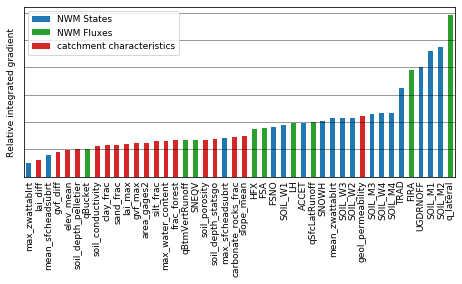

In [25]:
# get the colors based on the feature source
# grab colors for manual plotting
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colorz=[]
for cfs in df.feature_source:
    if cfs == 'atm':
        colorz.append(colors[1])
    if cfs == 'nwm_state':
        colorz.append(colors[0])
    if cfs == 'nwm_flux':
        colorz.append(colors[2])
    if cfs == 'cam':
        colorz.append(colors[3])

# Make a good looking plot
mpl.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(6.5,4.02))
df.plot(kind='bar', x='model_features', y='ig_pred_t', ax=ax, \
        color=colorz, label='_nolegend_')
plt.ylabel('Relative integrated gradient')
plt.xlabel('')
ax.grid(b=None, which='major', axis='y')
ax.set_yticklabels([])
ax.tick_params(direction='in', length=0, width=0, colors='k',
              grid_color='k', grid_alpha=0.5)

labelz = ['NWM States','NWM Fluxes', 'catchment characteristics']
colorz = [colors[0], colors[2], colors[3]]
for ilab, icol in zip(labelz,colorz):
    #Plot invisible bar graph but have the legends specified
    ax.bar(model_features, sum_all_ig_pred_t,width=0,color=icol,label=ilab)
ax.legend(loc='upper left')
#plt.title('Input attributions for LSTM+NWM post processor predictions')
plt.tight_layout()
#plt.savefig(MAIN_DIR+'igs_plots/igs_bar_all.png')
plt.show()
plt.close()

In [26]:
df=df.reset_index()

In [27]:
df = df.set_index('model_features')
df_slim = df.copy(deep=True)
df_slim = df_slim.drop(['mean_sfcheadsubrt','max_sfcheadsubrt','mean_zwattablrt','max_zwattablrt'], axis=0)
df_slim = df_slim.drop(['SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'], axis=0)
df_slim = df_slim.drop(['SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'], axis=0)

temp_mean=df.loc[('max_sfcheadsubrt','mean_sfcheadsubrt'),'ig_pred_t'].mean()
sfc = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_state'}, index=['sfcheadsubrt'])
df_slim = pd.concat([df_slim, sfc])

temp_mean=df.loc[('max_zwattablrt','mean_zwattablrt'),'ig_pred_t'].mean()
zwa = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_state'}, index=['zwattablrt'])
df_slim = pd.concat([df_slim, zwa])

temp_mean=df.loc[('SOIL_M1', 'SOIL_M2', 'SOIL_M3', 'SOIL_M4'),'ig_pred_t'].mean()
sm = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_state'}, index=['SOIL_M'])
df_slim = pd.concat([df_slim, sm])

temp_mean=df.loc[('SOIL_W1', 'SOIL_W2', 'SOIL_W3', 'SOIL_W4'),'ig_pred_t'].mean()
sw = pd.DataFrame({'ig_pred_t':temp_mean,'feature_source':'nwm_state'}, index=['SOIL_W'])
df_slim = pd.concat([df_slim, sw])

df=df.reset_index()
df_slim.index.names = ['model_features']
df_slim = df_slim.sort_values('ig_pred_t')
df_slim=df_slim.reset_index()

# Get rid of static catchment attributes
#df_slim = df_slim[df_slim.feature_source != 'cam']


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'so

In [28]:
pd.DataFrame({'model_features':'sfcheadsubrt', 'ig_pred_t':temp_mean, 'feature_source':'nwm'}, 
             index=[0])

,model_features,ig_pred_t,feature_source
0,sfcheadsubrt,42624.421326,nwm


/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:575: UserWarning: The handle <BarContainer object of 36 artists> has a label of '_nolegend_' which cannot be automatically added to the legend.
  ax.legend(handles, labels, loc="best", title=title)


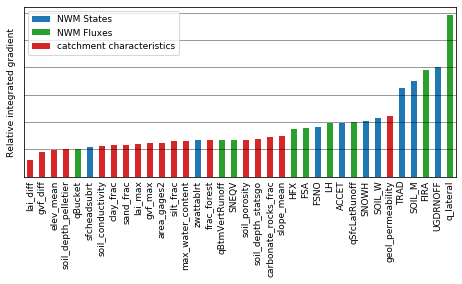

In [29]:
# get the colors based on the feature source
# grab colors for manual plotting
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colorz=[]
for cfs in df_slim.feature_source:
    if cfs == 'atm':
        colorz.append(colors[1])
    if cfs == 'nwm_state':
        colorz.append(colors[0])
    if cfs == 'nwm_flux':
        colorz.append(colors[2])
    if cfs == 'cam':
        colorz.append(colors[3])

# Make a good looking plot
mpl.rcParams.update({'font.size': 9})
fig, ax = plt.subplots(figsize=(6.5,4.02))
df_slim.plot(kind='bar', x='model_features', y='ig_pred_t', ax=ax, \
        color=colorz, label='_nolegend_')
plt.ylabel('Relative integrated gradient')
plt.xlabel('')
ax.grid(b=None, which='major', axis='y')
ax.set_yticklabels([])
ax.tick_params(direction='in', length=0, width=0, colors='k',
              grid_color='k', grid_alpha=0.5)

labelz = ['NWM States','NWM Fluxes', 'catchment characteristics']
colorz = [colors[0], colors[2], colors[3]]
for ilab, icol in zip(labelz,colorz):
    #Plot invisible bar graph but have the legends specified
    ax.bar(model_features, sum_all_ig_pred_t,width=0,color=icol,label=ilab)
ax.legend(loc='upper left')
#plt.title('Input attributions for LSTM+NWM post processor predictions')
plt.tight_layout()
#plt.savefig(MAIN_DIR+'igs_plots/igs_bar_all.png')
plt.show()
plt.close()

In [30]:
df_slim

,model_features,feature_source,ig_pred_t,index
0,lai_diff,cam,12204.587170,31.0
1,gvf_diff,cam,18241.064978,33.0
2,elev_mean,cam,19173.873913,26.0
3,soil_depth_pelletier,cam,20305.687829,34.0
4,qBucket,nwm_flux,20628.305151,2.0
5,sfcheadsubrt,nwm_state,22005.855055,NaN
6,soil_conductivity,cam,22407.518824,37.0
7,clay_frac,cam,22891.043223,41.0
8,sand_frac,cam,23197.814638,39.0
9,lai_max,cam,24173.823954,30.0
